In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Load the dataset
df = pd.read_csv('Functional_Requirements.csv', encoding='latin1')

# Define a function to clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Apply the clean_text function to the text column
df['comment_Text'] = df['comment_Text'].apply(clean_text)

# Create a dictionary to map sarcasm types to numerical values
y_dict = {'system requirement': 0, 'FunctionalCapabilities': 1, 'Security Requirements': 2, 'New feature': 3}  # Update as needed

# Filter the dataframe for the defined sarcasm types
df = df[df['Multi'].isin(y_dict.keys())]

# Split the dataset into X and y after cleaning and filtering
X = df['comment_Text'].tolist()  # Convert to list of strings
y = [y_dict[item] for item in df['Multi'].values]

# Convert the labels to categorical variables
num_classes = len(y_dict)
y = to_categorical(y, num_classes)

# Tokenize the data
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad the sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.20, random_state=42
)

# Define the RNN model with regularization
rnn_model = Sequential([
    Embedding(max_features, 128, input_length=maxlen),
    SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dense(num_classes, activation='softmax')
])

rnn_model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the model with early stopping
rnn_history = rnn_model.fit(X_train, y_train,
                            validation_split=0.2,
                            epochs=50, batch_size=128,
                            verbose=1, callbacks=[early_stopping])

# Evaluate the model on the test set
rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test, verbose=0)
print(f"RNN: Test Accuracy = {rnn_acc:.2f}")




d:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
d:\Anaconda\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
d:\Anaconda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.2730 - loss: 1.4158 - val_accuracy: 0.4397 - val_loss: 1.3371
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.3685 - loss: 1.3352 - val_accuracy: 0.5123 - val_loss: 1.1031
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.5009 - loss: 1.1200 - val_accuracy: 0.6183 - val_loss: 0.8332
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.6214 - loss: 0.8697 - val_accuracy: 0.6908 - val_loss: 0.6963
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.7087 - loss: 0.6909 - val_accuracy: 0.7243 - val_loss: 0.6357
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.7767 - loss: 0.5481 - val_accuracy: 0.7548 - val_loss: 0.5850
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8269 - loss: 0.4595 - val_accuracy: 0.7820 - val_loss: 0.5555
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.8618 - loss: 0.3813 - val_accuracy: 0.8028 

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


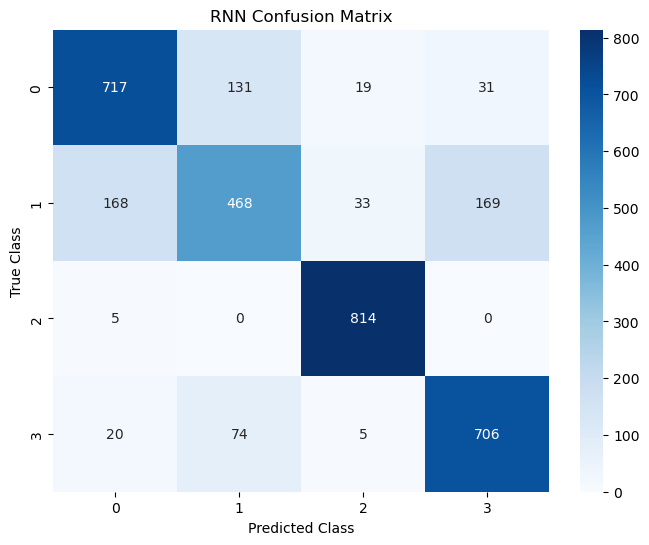

In [2]:
# Confusion Matrix
rnn_pred = np.argmax(rnn_model.predict(X_test), axis=-1)
rnn_cm = confusion_matrix(np.argmax(y_test, axis=-1), rnn_pred)

# Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()


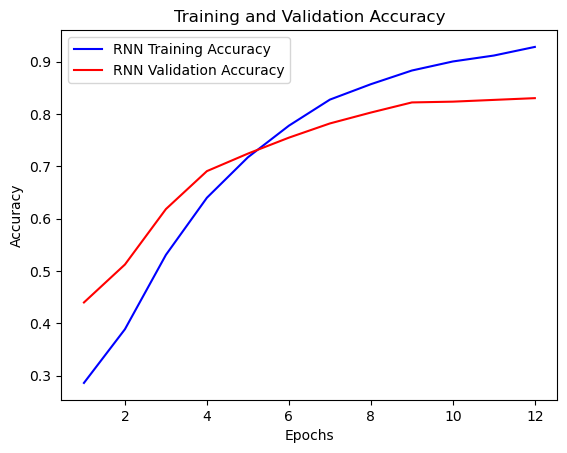

In [3]:

# Accuracy Graph
epochs = range(1, len(rnn_history.history['accuracy']) + 1)
plt.plot(epochs, rnn_history.history['accuracy'], 'b', label='RNN Training Accuracy')
plt.plot(epochs, rnn_history.history['val_accuracy'], 'r', label='RNN Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [4]:
# Calculate precision, recall, and F1-score for RNN
rnn_report = classification_report(np.argmax(y_test, axis=-1), rnn_pred)
print("RNN Classification Report:")
print(rnn_report)

RNN Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.80      0.79       898
           1       0.70      0.56      0.62       838
           2       0.93      0.99      0.96       819
           3       0.78      0.88      0.83       805

    accuracy                           0.81      3360
   macro avg       0.80      0.81      0.80      3360
weighted avg       0.80      0.81      0.80      3360



Epoch 1/50


d:\Anaconda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.2474 - loss: 1.4353 - val_accuracy: 0.2604 - val_loss: 1.4009
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 110ms/step - accuracy: 0.2603 - loss: 1.4056 - val_accuracy: 0.2448 - val_loss: 1.3940
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.2846 - loss: 1.3988 - val_accuracy: 0.3914 - val_loss: 1.3617
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.3461 - loss: 1.3537 - val_accuracy: 0.5037 - val_loss: 1.1415
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.4704 - loss: 1.1174 - val_accuracy: 0.5703 - val_loss: 0.8918
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.5806 - loss: 0.9208 - val_accuracy: 0.6455 - val_loss: 0.7918
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.6657 - loss: 0.7733 - val_accuracy: 0.6953 - val_loss: 0.7151
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 8s 100ms/step - accuracy: 0.7316 - loss: 0.6614 - val_accuracy: 0.7210 - va

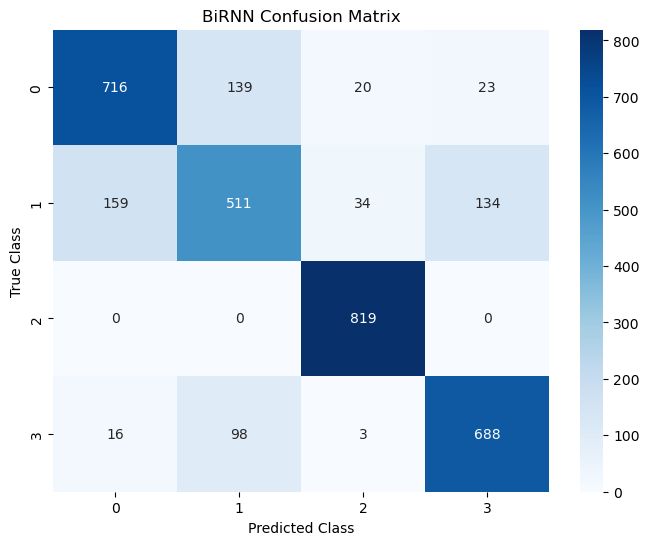

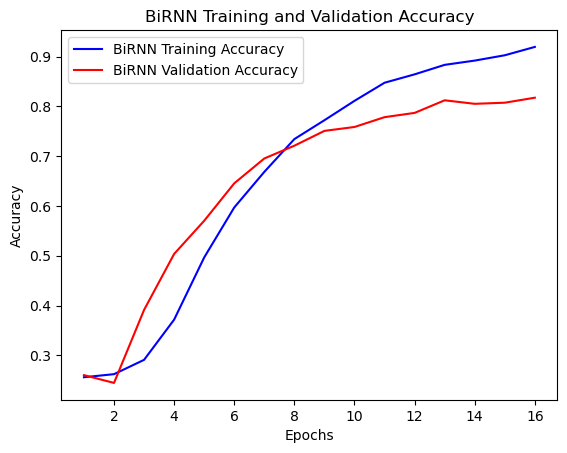

BiRNN Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       898
           1       0.68      0.61      0.64       838
           2       0.93      1.00      0.97       819
           3       0.81      0.85      0.83       805

    accuracy                           0.81      3360
   macro avg       0.81      0.82      0.81      3360
weighted avg       0.81      0.81      0.81      3360



In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Load the dataset
df = pd.read_csv('Functional_Requirements.csv', encoding='latin1')

# Define a function to clean the text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    filtered_tokens = [token for token in tokens if token not in stop_words]
    text = ' '.join(filtered_tokens)
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    text = ' '.join(lemmatized_tokens)
    return text

# Apply the clean_text function to the text column
df['comment_Text'] = df['comment_Text'].apply(clean_text)

# Create a dictionary to map sarcasm types to numerical values
y_dict = {'system requirement': 0, 'FunctionalCapabilities': 1, 'Security Requirements': 2, 'New feature': 3}

# Filter the dataframe for the defined sarcasm types
df = df[df['Multi'].isin(y_dict.keys())]

# Split the dataset into X and y after cleaning and filtering
X = df['comment_Text'].tolist()  # Convert to list of strings
y = [y_dict[item] for item in df['Multi'].values]

# Convert the labels to categorical variables
num_classes = len(y_dict)
y = to_categorical(y, num_classes)

# Tokenize the data
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

# Pad the sequences
maxlen = 100
X = pad_sequences(X, maxlen=maxlen)

# Apply oversampling to balance the classes
oversampler = RandomOverSampler(random_state=42)
X_resampled, y_resampled = oversampler.fit_resample(X, y)

# Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.20, random_state=42
)

# Define the BiRNN model with regularization
birnn_model = Sequential([
    Embedding(max_features, 128, input_length=maxlen),
    Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dense(num_classes, activation='softmax')
])

birnn_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Fit the BiRNN model with early stopping
birnn_history = birnn_model.fit(X_train, y_train,
                                validation_split=0.2,
                                epochs=50, batch_size=128,
                                verbose=1, callbacks=[early_stopping])

# Evaluate the BiRNN model on the test set
birnn_loss, birnn_acc = birnn_model.evaluate(X_test, y_test, verbose=0)
print(f"BiRNN: Test Accuracy = {birnn_acc:.2f}")

# Confusion Matrix for BiRNN
birnn_pred = np.argmax(birnn_model.predict(X_test), axis=-1)
birnn_cm = confusion_matrix(np.argmax(y_test, axis=-1), birnn_pred)

# Confusion Matrix Visualization for BiRNN
plt.figure(figsize=(8, 6))
sns.heatmap(birnn_cm, annot=True, fmt='d', cmap='Blues')
plt.title('BiRNN Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()

# Accuracy Graph for BiRNN
epochs = range(1, len(birnn_history.history['accuracy']) + 1)
plt.plot(epochs, birnn_history.history['accuracy'], 'b', label='BiRNN Training Accuracy')
plt.plot(epochs, birnn_history.history['val_accuracy'], 'r', label='BiRNN Validation Accuracy')
plt.title('BiRNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate precision, recall, and F1-score for BiRNN
birnn_report = classification_report(np.argmax(y_test, axis=-1), birnn_pred)
print("BiRNN Classification Report:")
print(birnn_report)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


C:\Users\nasib\AppData\Local\Temp\ipykernel_16352\1583194834.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


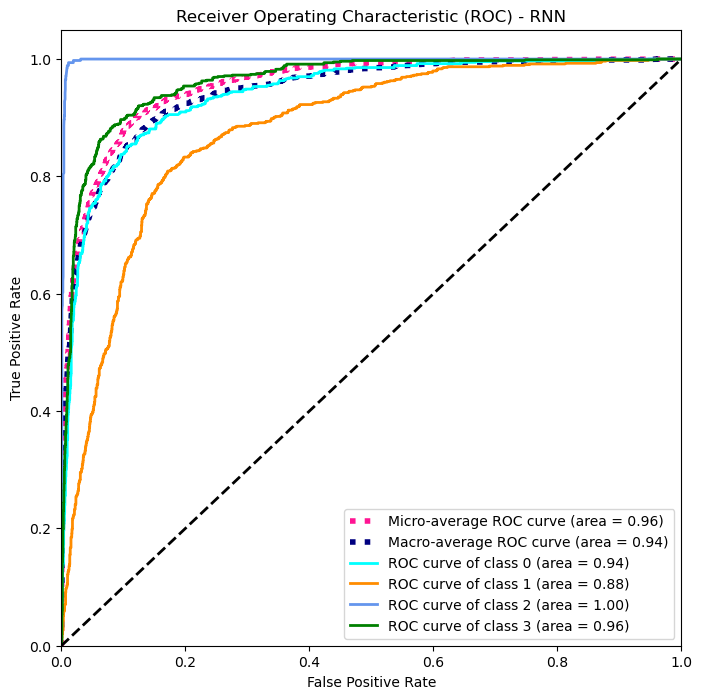

105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


C:\Users\nasib\AppData\Local\Temp\ipykernel_16352\1583194834.py:28: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


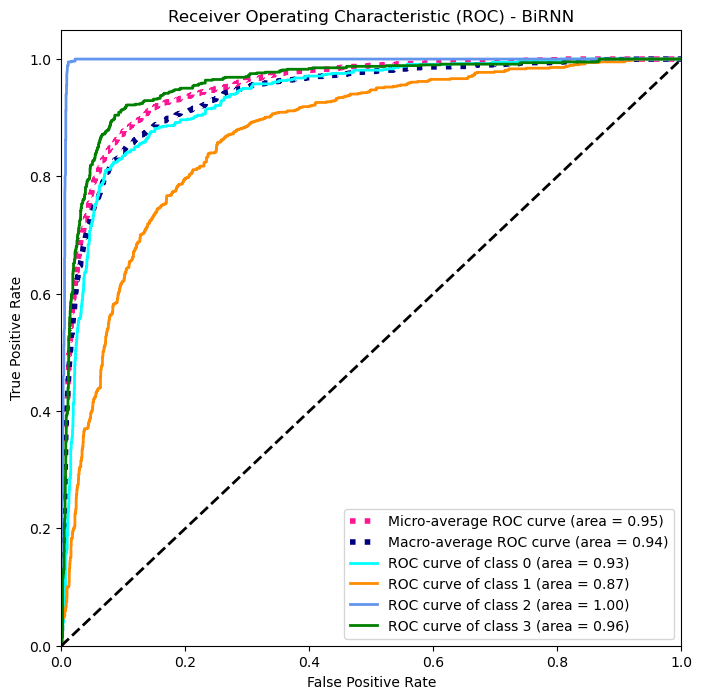

In [6]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

def plot_multiclass_roc(model, X_test, y_test, n_classes, model_name):
    # Compute ROC curve and ROC area for each class
    y_score = model.predict(X_test)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 8))
    
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'Macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curve for RNN
plot_multiclass_roc(rnn_model, X_test, y_test, num_classes, 'RNN')

# Plot ROC curve for BiRNN
plot_multiclass_roc(birnn_model, X_test, y_test, num_classes, 'BiRNN')
